In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [17]:
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        alpha = K.softmax(e, axis=1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

def build_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=1, padding='same')(x)

    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Attention()(x)

    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    return model

def prepare_data(df, time_steps=5):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df[i:i+time_steps, :])
        y.append(df[i+time_steps, 3])  # closing price is 3rd column
    return np.array(X), np.array(y)

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, label="Actual Closing Price")
    plt.plot(y_pred, label="Predicted Closing Price")
    plt.title("INFY Stock Closing Price Prediction (CNN-BiLSTM-AM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [18]:
data = pd.read_csv("INFY.csv", index_col=0)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7898 entries, 1994-11-03 to 2025-04-30
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   opening_price  7898 non-null   float64
 1   highest_price  7898 non-null   float64
 2   lowest_price   7898 non-null   float64
 3   closing_price  7898 non-null   float64
 4   volume         7898 non-null   float64
 5   turnover       7898 non-null   float64
 6   ups_and_downs  7898 non-null   float64
 7   change         7898 non-null   float64
dtypes: float64(8)
memory usage: 555.3+ KB


In [20]:
# data from 1994-11-03 to 2025-04-24
data.head()

,opening_price,highest_price,lowest_price,closing_price,volume,turnover,ups_and_downs,change
1994-11-03,451.0,451.0,450.0,450.0,400.0,180100.0,-0.221729,0.000000
1994-11-09,475.0,475.0,475.0,475.0,100.0,47500.0,0.000000,5.555556
1994-11-15,445.0,445.0,445.0,445.0,100.0,44500.0,0.000000,-6.315789
1994-11-16,445.0,445.0,445.0,445.0,200.0,89000.0,0.000000,0.000000
1994-11-17,445.0,445.0,445.0,445.0,100.0,44500.0,0.000000,0.000000


Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1921 - val_loss: 0.0128
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0387 - val_loss: 0.0113
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0348 - val_loss: 0.0157
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0353 - val_loss: 0.0117
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0330 - val_loss: 0.0249
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0311 - val_loss: 0.0117
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0324 - val_loss: 0.0123
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0313 - val_loss: 0.0108
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0340 - val_loss: 0.0136
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0294 - val_loss: 0.0110
Epoch 11/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0298 - val_loss: 0.0126
Epoch 12/100
108/108 ━━━━━━━━━

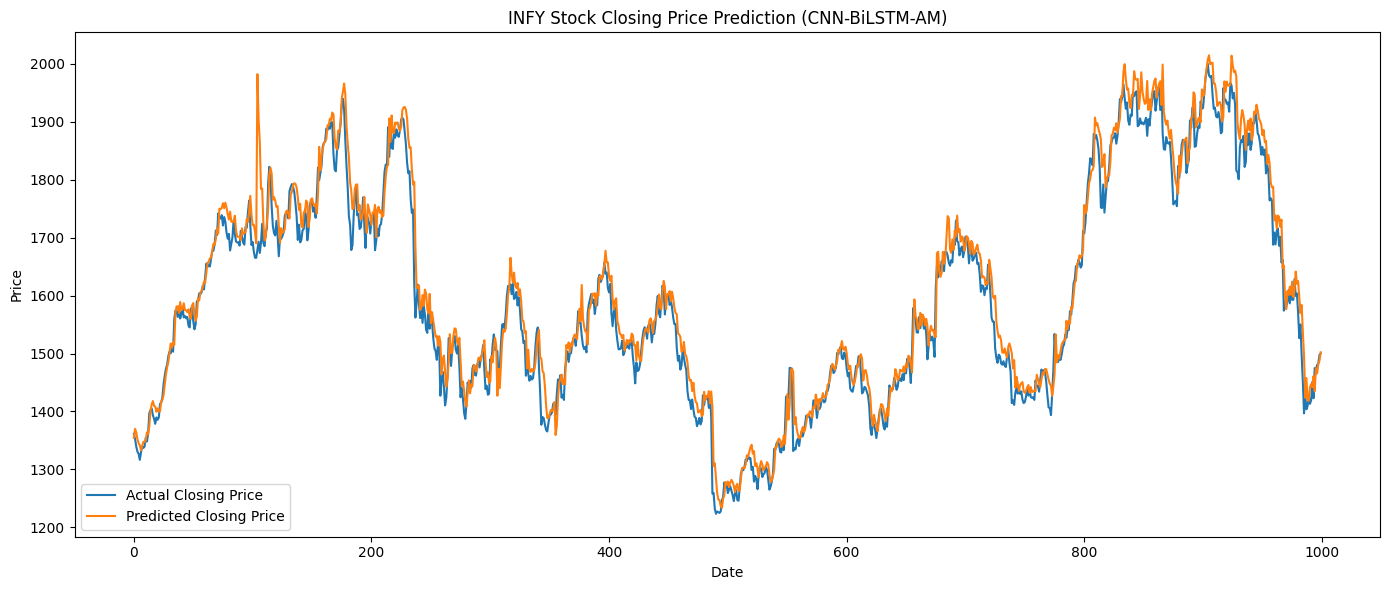

In [22]:
# features
features = data[['opening_price', 'highest_price', 'lowest_price', 'closing_price', 'volume', 'turnover', 'ups_and_downs', 'change']].values

# standardize
scaler = StandardScaler()
features = scaler.fit_transform(features)

X, y = prepare_data(features, time_steps=5)

# train - test split
X_train, X_test = X[:-1000], X[-1000:]
y_train, y_test = y[:-1000], y[-1000:]

# build  model
model = build_model(X.shape[1:])
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError())

# fit
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

# predictions
y_pred = model.predict(X_test).flatten()

# re-scale
y_test_unscaled = y_test * scaler.scale_[3] + scaler.mean_[3]
y_pred_unscaled = y_pred * scaler.scale_[3] + scaler.mean_[3]

# metrics
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

# graph
plot_predictions(y_test_unscaled, y_pred_unscaled)